# W266 Final Project - Predicting Amazon Review Helpfulness

Annie Lee, annie.y.lee@berkeley.edu

Le Gu, legu@berkeley.edu 

# Overview

In this notebook, we tested out several machine learning approaches for predicting the usefulness of customer reviews, specifically online product reviews. We work with the Amazon Product Review dataset and focus on applying NLP techniques and building deep learning models, such as RNN and LSTM, to improve the prediction accuracy. 
  


We chose to focus on a subset of the <a href="http://jmcauley.ucsd.edu/data/amazon/">Amazon Product Data</a>. Specifically, we use reviews for products from the Clothing, Shoes and Jewelry category, which consists of 278,677 Amazon reviews. Each review consists of 7 fields: reviewer id, product id, helpfulness rating, review text, star rating, summary of review, and review time. In this section, we cover a few of the interesting characteristics of our dataset.

# 1. Set up

## 1.1 Environment

In [3]:
# Imports
import pandas as pd
import numpy as np
import gzip
import time
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# Sklearn libraries.
from sklearn import datasets, linear_model, ensemble, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
import string

from collections import Counter
#deep learning library

import json, os, re, shutil, sys, time
import collections, itertools
import unittest
from IPython.display import display, HTML

# NLTK for NLP utils and corpora
import nltk

# NumPy and TensorFlow
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1."))

# utils.pretty_print_matrix uses Pandas. Configure float format here.
import pandas as pd
pd.set_option('float_format', lambda f: "{0:.04f}".format(f))

# Helper libraries
from shared_lib import utils, vocabulary, tf_embed_viz

from random import randint
from numpy import random
from numpy.random import multinomial

random.seed(10)
import utils, vocabulary
from itertools import product


## 1.2 Read Data

In [4]:
# Unzip gz file.
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

# Load JSON into dataframe.
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [5]:
start = time.time()
df = getDF('/home/legu/data/reviews_Clothing_Shoes_and_Jewelry_5.json.gz')
end = time.time()
print("Time Used %fs" %(end - start))

Time Used 43.249688s


## 1.3 Data Wrangling

### 1.3.1 Data transformation

In [6]:
helpfulness = []
total_votes = []
for i in df['helpful']:
    if i[1] == 0:
        helpfulness.append(np.nan)
        total_votes.append(np.nan)
    else:
        helpfulness.append(float(i[0])/i[1])
        total_votes.append(i[1])
        
# Convert to numpy array.
helpfulness = np.array(helpfulness)
total_votes = np.array(total_votes)

### 1.3.2 Remove wrong/nan entries

In [7]:
for i, row in df.iterrows():
    helpful = row['helpful']
    if helpful[0] > helpful[1]:
        print(row)

reviewerID                                           A353U0L2HAMSHV
asin                                                     B000JD2614
reviewerName                   Cricket "Living life and loving it!"
helpful                                                      [4, 2]
unixReviewTime                                           1234828800
reviewText        I have been waiting for these to go on sale fo...
overall                                                      5.0000
reviewTime                                              02 17, 2009
summary                                              A gift for me!
Name: 30730, dtype: object


In [8]:
#  remove the invalid entries
helpfulness_clean = np.delete(helpfulness, 30730)
doc = np.array(df['reviewText'])
doc_clean = np.delete(doc, 30730)

# remove the nan values
nonnan_doc_clean = doc_clean[~np.isnan(helpfulness_clean)]
nonnan_helpfulness_clean = helpfulness_clean[~np.isnan(helpfulness_clean)]
y = np.reshape(nonnan_helpfulness_clean,(-1,1))

#binarize

y_norm2 = np.argmax(np.concatenate((1-y,y), axis = 1),1)
y_norm = 1-np.argmax(np.concatenate((y,1-y), axis = 1),1)

# 2. Data Exploration

## 2.1 Overview

In [8]:
print df.columns

print df['reviewText'][0]

df.head(5)

Index([u'reviewerID', u'asin', u'reviewerName', u'helpful', u'unixReviewTime',
       u'reviewText', u'overall', u'reviewTime', u'summary'],
      dtype='object')
This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++


,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",1297468800,This is a great tutu and at a really great pri...,5.0000,"02 12, 2011",Great tutu- not cheaply made
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",1358553600,I bought this for my 4 yr old daughter for dan...,5.0000,"01 19, 2013",Very Cute!!
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",1357257600,What can I say... my daughters have it in oran...,5.0000,"01 4, 2013",I have buy more than one
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]",1398556800,"We bought several tutus at once, and they are ...",5.0000,"04 27, 2014","Adorable, Sturdy"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",1394841600,Thank you Halo Heaven great product for Little...,5.0000,"03 15, 2014",Grammy's Angels Love it


## 2.2 Helpful Votes

In [16]:
print "average # votes for reviews with votes: %f" %np.nanmean(total_votes)
print "min # votes for reviews with votes: %i" %np.nanmin(total_votes)
print "max # votes for reviews with votes: %i" %np.nanmax(total_votes)

average # votes for reviews with votes: 4.305961
min # votes for reviews with votes: 1
max # votes for reviews with votes: 1267


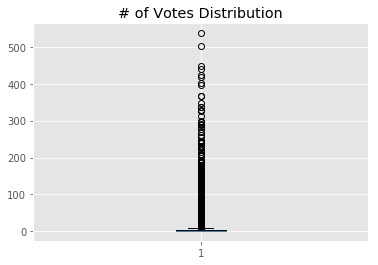

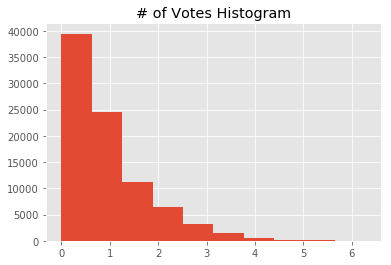

In [19]:
# Create array that contains total votes per review with >0 votes.
non_zero_total_votes = total_votes[np.isfinite(total_votes)]

# Remove outlier.
non_zero_total_votes_minus_outliers = non_zero_total_votes[np.where(non_zero_total_votes < 1267)]

# Plot boxplot.
plt.figure()
plt.boxplot(non_zero_total_votes_minus_outliers)
plt.title('# of Votes Distribution')
# Plot histogram using log(total votes) due to right skewed distribution.
plt.figure()
plt.hist(np.log(non_zero_total_votes_minus_outliers))
plt.title('# of Votes Histogram')
plt.show()

## 2.3 Helpfulness Score

In [9]:
print "average helpfulness %f" %np.nanmean(helpfulness)
print "number of reviews with helpfulness score: %i" %np.count_nonzero(~np.isnan(helpfulness))
print "total reviews: ", len(df)
print "percent of reviews with helpfulness score: ", (np.count_nonzero(~np.isnan(helpfulness)) / float(len(df)))

average helpfulness 0.780014
number of reviews with helpfulness score: 87021
total reviews:  278677
percent of reviews with helpfulness score:  0.312264736595


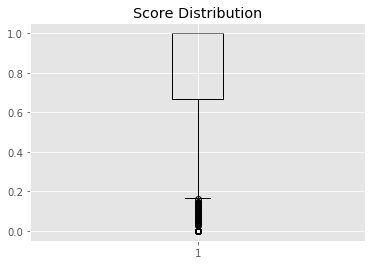

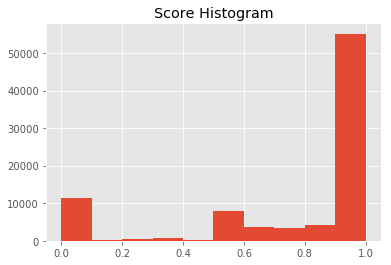

In [14]:
# Plot boxplot.
# nonnan_helpfulness = helpfulness[~np.isnan(helpfulness)]

plt.figure()
plt.boxplot(nonnan_helpfulness_clean)
plt.title('Score Distribution')

# Plot histogram
plt.figure()
plt.hist(nonnan_helpfulness_clean)
plt.title('Score Histogram')
plt.show()

## 2.4 Review Length

In [20]:
# Compute review lengths.
review_lengths = np.array([len(x) for x in df['reviewText']])
print review_lengths
print "average review length: %i" %np.mean(review_lengths)
print "min review length: %i" %np.min(review_lengths)
print "max review length: %i" %np.max(review_lengths)

[ 172  306  312 ...,  914 1126 1295]
average review length: 315
min review length: 0
max review length: 22646


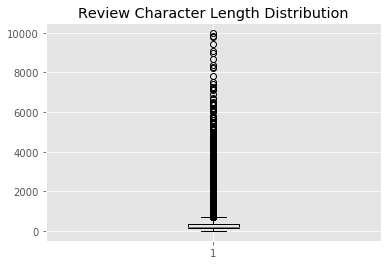

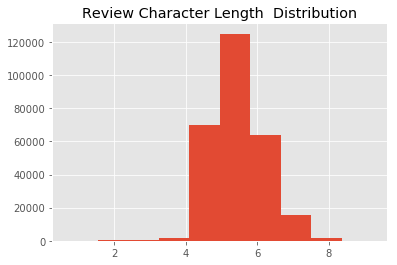

In [23]:
# Remove outliers.
review_lengths_minus_outliers = review_lengths[np.where(np.logical_and(review_lengths > 0, review_lengths < 10000))]

# Plot boxplot.
plt.figure()
plt.boxplot(review_lengths_minus_outliers)
plt.title('Review Character Length Distribution')
# # Plot histogram using log(review length) due to right skewed distribution.
plt.figure()
plt.hist(np.log(review_lengths_minus_outliers))
plt.title('Review Character Length  Distribution')
plt.show()

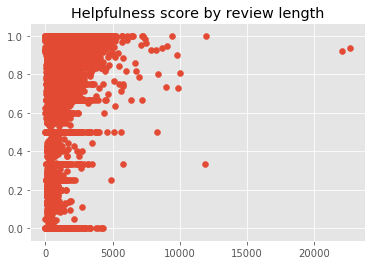

In [27]:
# Remove invalid and nan values.
helpfulness_clean = np.delete(helpfulness, 30730)
review_lengths_clean = np.delete(review_lengths, 30730)
nonnan_helpfulness_clean = helpfulness_clean[~np.isnan(helpfulness_clean)]
nonnan_review_lengths_clean = review_lengths_clean[~np.isnan(helpfulness_clean)]

plt.figure()
plt.scatter(nonnan_review_lengths_clean, nonnan_helpfulness_clean)
plt.title("Helpfulness score by review length")
plt.show()

In [28]:
# Compute correlation.
np.corrcoef(nonnan_review_lengths_clean, nonnan_helpfulness_clean)[1,0]

0.054565284474689578

In [32]:
review_word_lengths = np.array([len(utils.tokenize(x)) for x in df['reviewText']])
non_zero_review_word_lengths = review_word_lengths[np.where(review_word_lengths > 0)]
print "average review length: %i" %np.mean(review_word_lengths)
print "median review length: %i" %np.median(review_word_lengths)
print "min review length: %i" %np.min(review_word_lengths)
print "max review length: %i" %np.max(review_word_lengths)
print "95th percentile: ", np.percentile(review_word_lengths, 95)
print "90th percentile: ", np.percentile(review_word_lengths, 90)

average review length: 68
median review length: 47
min review length: 0
max review length: 4571
95th percentile:  186.0
90th percentile:  136.0


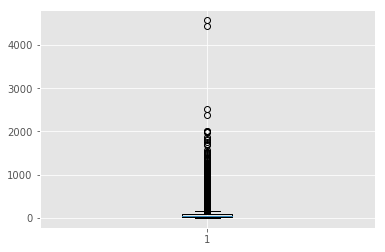

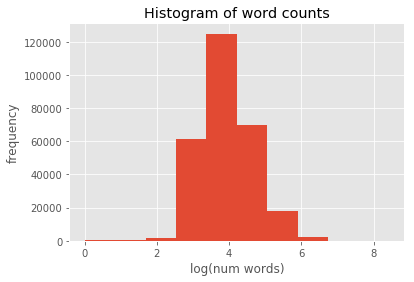

In [33]:
# Plot boxplot.
plt.figure()
plt.boxplot(non_zero_review_word_lengths)

# # Plot histogram using log(review length) due to right skewed distribution.
plt.figure()
# plt.hist(non_zero_review_word_lengths)

plt.xlabel('log(num words)')
plt.ylabel('frequency')
plt.title('Histogram of word counts')
plt.hist(np.log(non_zero_review_word_lengths))

plt.show()

## 2.5 Review Score

In [34]:
review_scores = np.array(df['overall'])
print "average review score: %i" %np.mean(review_scores)
print "min review score: %i" %np.min(review_scores)
print "max review score: %i" %np.max(review_scores)

average review score: 4
min review score: 1
max review score: 5


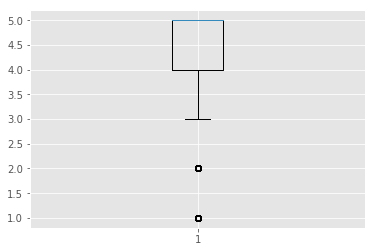

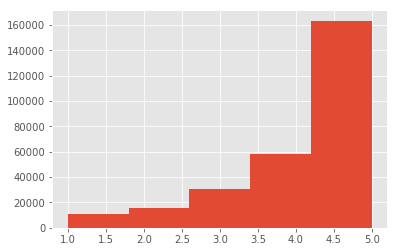

In [35]:
# Plot boxplot.
plt.figure()
plt.boxplot(review_scores)

# # Plot histogram.
plt.figure()
plt.hist(review_scores, bins=5)

plt.show()

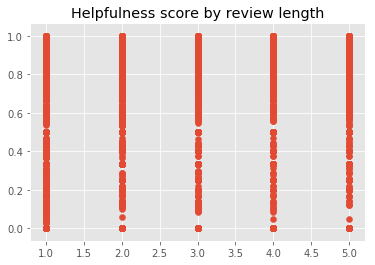

In [36]:
# Remove invalid and nan values.
review_scores_clean = np.delete(review_scores, 30730)
nonnan_review_scores_clean = review_scores_clean[~np.isnan(helpfulness_clean)]

# Print scatterplot of review length to helpfulness score.
plt.figure()
plt.scatter(nonnan_review_scores_clean, nonnan_helpfulness_clean)
plt.title("Helpfulness score by review length")
plt.show()

# 3. Data Input and Configuration

## 3.1 DataSet Prep

### 3.1.1 Prepare Training, Dev, and Test

In [9]:
n_total_samples = len(nonnan_doc_clean)# or whatever it is

indices = np.arange(n_total_samples)
inds_split = multinomial(n=1,
                         pvals=[0.8, 0.1, 0.1],
                         size=n_total_samples).argmax(axis=1)

train_inds = indices[inds_split==0]
test_inds  = indices[inds_split==1]
dev_inds   = indices[inds_split==2]

x_train = nonnan_doc_clean[train_inds]
y_train = y[train_inds]
y_train_norm = y_norm[train_inds]
x_test = nonnan_doc_clean[test_inds]
y_test = y[test_inds]
y_test_norm = y_norm[test_inds]
x_dev = nonnan_doc_clean[dev_inds]
y_dev = y[dev_inds]
y_dev_norm = y_norm[dev_inds]

### 3.1.3 Downsampling

In [10]:
ind_0 = np.where(y_train_norm == 0)[0]
ind_1 = np.where(y_train_norm == 1)[0]
ind_downsamp = np.random.choice(ind_1,size = len(ind_0),replace =0)
x_train_res= np.concatenate( [x_train[ind_downsamp] ,x_train[ind_0]],axis=0)
y_train_res= np.concatenate( [y_train[ind_downsamp] ,y_train[ind_0]],axis=0)
y_train_norm_res= np.concatenate( [y_train_norm[ind_downsamp] ,y_train_norm[ind_0]],axis=0)

### 3.1.2 Upsampling

In [11]:
ind_0 = np.where(y_train_norm == 0)[0]
ind_1 = np.where(y_train_norm == 1)[0]
ind_upsamp = np.random.choice(ind_0,size = len(ind_1),replace =1)
x_train_res= np.concatenate( [x_train[ind_upsamp] ,x_train[ind_1]],axis=0)
y_train_res= np.concatenate( [y_train[ind_upsamp] ,y_train[ind_1]],axis=0)
y_train_norm_res= np.concatenate( [y_train_norm[ind_upsamp] ,y_train_norm[ind_1]],axis=0)

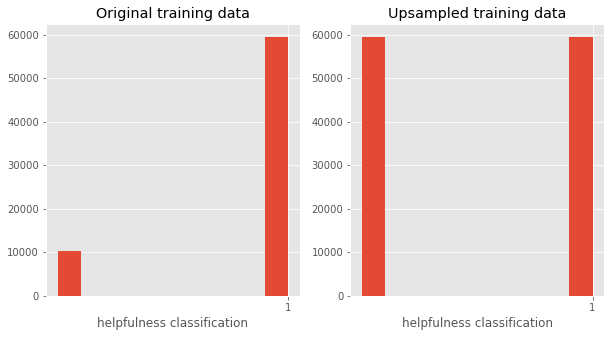

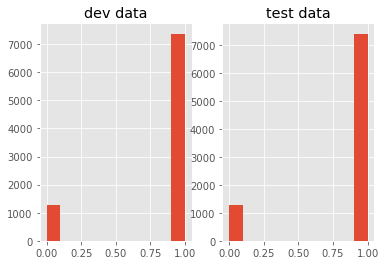

Training data set is of size 69646: there are 10195 0 lables, and 59451 1 labels. After upsampling, there are total 118902 samples


In [12]:
plt.figure(1, figsize=(10,5))

plt.subplot(121)
plt.hist(y_train_norm)
plt.title('Original training data')
plt.xlabel('helpfulness classification')
plt.xticks(range(1, 2))

plt.subplot(122)
plt.hist(y_train_norm_res)
plt.title('Upsampled training data')
plt.xlabel('helpfulness classification')
plt.xticks(range(1, 2))

plt.figure(2)
plt.subplot(121)
plt.hist(y_dev_norm)
plt.title('dev data')

plt.subplot(122)
plt.hist(y_test_norm)
plt.title('test data')
plt.show()



print ('Training data set is of size %i: there are %i 0 lables, and %i 1 labels. After upsampling, there are total %i samples'
       %(len(x_train),len(np.where(y_train_norm == 0)[0]),len(np.where(y_train_norm == 1)[0]),len(x_train_res)))


## 3.2 Extract Features

### 3.2.1 TF-IDF

In [46]:
token_dict_train = {}
token_dict_dev = {}

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens

for i, text in enumerate(x_train_res):
    lowers = text.lower()
    no_punctuation = lowers.translate(None, string.punctuation)
    token_dict_train[i] = no_punctuation

for i, text in enumerate(x_dev):
    lowers = text.lower()
    no_punctuation = lowers.translate(None, string.punctuation)
    token_dict_dev[i] = no_punctuation
    
#this can take some time
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
tfs_train = tfidf.fit_transform(token_dict_train.values())
tfs_dev = tfidf.transform(token_dict_dev.values())

In [47]:
print(tfs_train.shape)
print(tfs_dev.shape)
print(len(y_train_norm_res))
print(len(y_dev))

(118902, 93061)
(8657, 93061)
118902
8657


In [52]:
print ("Shape of token_dict: ", len(token_dict_train))
print ("Shape of tfs: ", tfs_train.shape)
print (tfs_train[0,:] )#sparse matrix
print (token_dict_train[0])
print ("Items in vocab: ", len(tfidf.vocabulary_))
print ("ID of tutu: ", tfidf.vocabulary_['tutu'])

Shape of token_dict:  118902
Shape of tfs:  (118902, 93061)
  (0, 65541)	0.200862892321
  (0, 21853)	0.196122149071
  (0, 33296)	0.252683901074
  (0, 47963)	0.157854073581
  (0, 92727)	0.333304607018
  (0, 89299)	0.245604132923
  (0, 50079)	0.267087611514
  (0, 58683)	0.381606246613
  (0, 76944)	0.409651492854
  (0, 80658)	0.30690278818
  (0, 12721)	0.310817716593
  (0, 81527)	0.29230009911
these are really comfortable and they do feel like youre wearing nothing  they will make your package stick out but thats not a bad thing is it
Items in vocab:  93061
ID of tutu:  84885


### 3.2.2 BOW

In [50]:
cv = CountVectorizer(tokenizer=tokenize, stop_words='english', dtype=np.float32, max_features=10000)
cv_features_train = cv.fit_transform(token_dict_train.values())
cv_features_dev = cv.transform(token_dict_dev.values())


### 3.2.3 Word2Vec

In [15]:
class SimpleDataIterator():
    def __init__(self, df):
        self.df = df
        self.size = len(self.df)
        self.epochs = 0
#         self.shuffle()
        self.cursor = 0

    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.cursor = 0

    def next_batch(self, n):
        if self.cursor+n-1 > self.size:
            self.epochs += 1
            self.shuffle()
        res = self.df.ix[self.cursor:self.cursor+n-1]
        self.cursor += n
        return res['list_words'], res['label'] 
    


In [16]:
##this helps to make sure each sentence have the same length (max_len)
class PaddedDataIterator(SimpleDataIterator):
    def next_batch(self, n, max_len):
        if self.cursor+n > self.size or self.cursor==0:
            self.epochs += 1
            self.shuffle()
#             self.max_len = max_len
        res = self.df.ix[self.cursor:self.cursor+n-1]
        self.cursor += n

        # Pad sequences with 0s so they are all the same length
        maxlen = max_len
        x = np.zeros([n, maxlen], dtype=np.int32)
        for i, x_i in enumerate(x):
            l=len(res['list_words'].values[i]) ##list length
            if l>maxlen: 
                x_i[:maxlen] = res['list_words'].values[i][:max_len]
            else:
                x_i[:l] = res['list_words'].values[i][:l]

        return x, np.asarray(res['label']) 
    def pad_sentences(self, max_len):
        maxlen = max_len
        x = np.zeros([len(self.df), maxlen], dtype=np.int32)
        for i, x_i in enumerate(x):
            l=len(self.df['list_words'].values[i]) ##list length
            if l>maxlen: 
                x_i[:maxlen] = self.df['list_words'].values[i][:max_len]
            else:
                x_i[:l] = self.df['list_words'].values[i][:l]

        return x, np.asarray(self.df['label'])

#### 3.2.3.1 Simple Vector

In [17]:
def get_tokens(docs):
    tokens =[]
    for i in docs:
        lowers = i.lower()
        #remove the punctuation using the character deletion step of translate
        no_punctuation = lowers.translate(None, string.punctuation)
        token = nltk.word_tokenize(no_punctuation)
        tokens.extend(token)
    return tokens

V = 10000
def build_dataset(words):
    
    # Leave the last index for all other words.
    count = collections.Counter(words).most_common(V-1)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary

def transform_words_to_index(words, dictionary):
    #build sample data
    ids = []
    for i in words:
        lowers = i.lower()
        #remove the punctuation using the character deletion step of translate
        no_punctuation = lowers.translate(None, string.punctuation)
        token = nltk.word_tokenize(no_punctuation)
        j = []
        for w in token:
            if w in dictionary:
                j.append(dictionary[w])
            # Set token_id to vocab size - 1 if word not in top words
            # since this is zero indexed.
            else:
                j.append(V-1)
        ids.append(j)
    return ids

In [18]:
tokens = get_tokens(x_train_res)
dic, rev_dict = build_dataset(tokens)

In [19]:
x_train_res_ids = transform_words_to_index(x_train_res, dic)
x_dev_ids = transform_words_to_index(x_dev, dic)
x_test_ids = transform_words_to_index(x_test, dic)

In [20]:
#combine the list of words index and label into a dataframe
train_df = pd.DataFrame(np.column_stack([x_train_res_ids,y_train_norm_res]), 
                        columns=['list_words', 'label'])
train_df = train_df.astype(dtype={'list_words': 'object', 'label': 'int64'})
#combine the list of words index and label into a dataframe
dev_df = pd.DataFrame(np.column_stack([x_dev_ids,y_dev_norm]), 
                               columns=['list_words', 'label'])
dev_df = dev_df.astype(dtype={'list_words': 'object', 'label': 'int64'})
#combine the list of words index and label into a dataframe
test_df = pd.DataFrame(np.column_stack([x_test_ids,y_test_norm]), 
                               columns=['list_words', 'label'])
test_df = test_df.astype(dtype={'list_words': 'object', 'label': 'int64'})

In [21]:
train_df.head()

,list_words,label
0,"[18, 14, 53, 55, 2, 12, 69, 115, 27, 339, 104,...",0
1,"[1, 21, 26, 313, 20, 9, 291, 1, 21, 660, 94, 1...",0
2,"[9999, 79, 3, 37, 150, 15, 2846, 25, 3, 1438, ...",0
3,"[1, 187, 5, 21, 26, 631, 2, 76, 5, 7, 3, 597, ...",0
4,"[1, 67, 0, 72, 7, 71, 3, 464, 124, 49, 0, 119,...",0


#### 3.2.3.2 GloVe

In [26]:
filename = '/home/legu/data/glove.6B.50d.txt'
def loadGloVe(filename):
    vocab = []
    embd = []
    vocab_dict = {}
    file = open(filename,'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        vocab.append(row[0])
        vocab_dict[row[0]] = len(vocab_dict)
        embd.append(row[1:])
    print('Loaded GloVe!')
    file.close()
    return vocab,embd,vocab_dict
vocab,embd,dic_glove = loadGloVe(filename)
vocab_size = len(vocab)
embedding_dim = len(embd[0])
embedding = np.asarray(embd)

Loaded GloVe!


In [27]:
def transform_words_to_index_glove(words, dictionary):
    #build sample data
    ids = []
    for i in words:
        lowers = i.lower()
        #remove the punctuation using the character deletion step of translate
        no_punctuation = lowers.translate(None, string.punctuation)
        token = nltk.word_tokenize(no_punctuation)
        j = []
        for w in token:
            if w in dictionary:
                j.append(dictionary[w])
            # Set token_id to vocab size - 1 if word not in top words
            # since this is zero indexed.
#             else:
#                 j.append(V-1)
        ids.append(j)
    return ids

In [28]:
x_train_res_ids_glove = transform_words_to_index_glove(x_train_res, dic_glove)
x_dev_ids_glove = transform_words_to_index_glove(x_dev, dic_glove)
x_test_ids_glove = transform_words_to_index_glove(x_test, dic_glove)

In [29]:
#combine the list of words index and label into a dataframe
train_df_glove = pd.DataFrame(np.column_stack([x_train_res,x_train_res_ids_glove,y_train_norm_res]), 
                        columns=['words','list_words', 'label'])
train_df_glove = train_df_glove.astype(dtype={'words': 'object','list_words': 'object', 'label': 'int64'})
#combine the list of words index and label into a dataframe
dev_df_glove = pd.DataFrame(np.column_stack([x_dev, x_dev_ids_glove,y_dev_norm]), 
                             columns=['words','list_words', 'label'])
dev_df_glove = dev_df_glove.astype(dtype={'words': 'object','list_words': 'object', 'label': 'int64'})
#combine the list of words index and label into a dataframe
test_df_glove = pd.DataFrame(np.column_stack([x_test,x_test_ids_glove,y_test_norm]), 
                               columns=['words','list_words', 'label'])
test_df_glove = test_df_glove.astype(dtype={'words': 'object','list_words': 'object', 'label': 'int64'})

# 4. Build Model

## 4.1 Machine Learning Model

### 4.1.1 Logistic Regression

##### TF-IDF Features

In [48]:
regr2 = linear_model.LogisticRegression()

# Train the model using the training sets
regr2.fit(tfs_train, y_train_norm_res)

# make predictions
predicted2 = regr2.predict(tfs_dev)

# The coefficients
print'Coefficients:',
print regr2.coef_
# The mean squared error
# print("Mean squared error: %.2f"
#       % np.mean((predicted2 - y_dev) ** 2))
# Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % regr2.score(X_test, y_test_norm))
print(metrics.classification_report(y_dev_norm, predicted2))

Coefficients: [[-0.30477808 -0.2946582  -0.12618387 ...,  0.07476122 -0.60590482
   0.16658943]]
             precision    recall  f1-score   support

          0       0.22      0.43      0.29      1284
          1       0.88      0.73      0.80      7373

avg / total       0.78      0.69      0.73      8657



##### Word Count Vector

In [53]:
cv_regr = linear_model.LogisticRegression()

# Train the model using the training sets
cv_regr.fit(cv_features_train, y_train_norm_res)
# make predictions
cv_predicted = cv_regr.predict(cv_features_dev)

# The coefficients
print('Coefficients:')
print (cv_regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((cv_predicted - y_dev_norm) ** 2))
print(metrics.classification_report(y_dev_norm, cv_predicted))

Coefficients:
[[-0.01055903  0.14219806 -1.5598744  ...,  0.69521415 -0.22971256
   0.75078171]]
Mean squared error: 0.35
             precision    recall  f1-score   support

          0       0.20      0.47      0.29      1284
          1       0.88      0.68      0.77      7373

avg / total       0.78      0.65      0.70      8657



### 4.1.2 Random Forest

In [53]:
rf = ensemble.RandomForestClassifier(n_estimators = 100)

# Train the model using the training sets
rf.fit(tfs_train, y_train_norm_res)
print(rf)
# make predictions
predicted_rf = rf.predict(tfs_dev)

# The mean squared error
# print("Mean squared error: %.2f"
#       % np.mean((predicted_rf - y_dev_norm) ** 2))
# Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % regr2.score(X_test, y_test_norm)
print(metrics.classification_report(y_dev_norm, predicted_rf))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.48      0.03      0.05      1284
          1       0.85      0.99      0.92      7373

avg / total       0.80      0.85      0.79      8657



## 4.2 Deep Learning

In [22]:
"""
Simple demo of a scatter plot.
"""
import numpy as np
import matplotlib.pyplot as plt

def visualizeTraining(iters, costs, accs):

    x = iters
    y = costs
    z = accs

    plt.scatter(x, y )
    plt.xlabel('iterations')
    plt.ylabel('cost')
    plt.show()

    plt.scatter(x, z)
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.show()

### 4.2.1 Simple NN

##### Trained Embeddings

In [23]:
'''
Simple Model
'''

from __future__ import print_function

import tensorflow as tf
import sklearn as sk
from tensorflow.contrib import rnn

# Reset defaul graph.
tf.reset_default_graph()
tf.set_random_seed(42)

######################## 
### MODEL PARAMETERS ###
######################## 

# Network Parameters
# Context window size (sentence length)
N = 100
# Embedding size
M = 50
# Hidden units
H = 50 # hidden layer num of features
n_classes = 2  
V = 8000


#################################
### PLACEHOLDER AND GRAPH ###
#################################

with tf.name_scope("Inputs"):
    ids_ = tf.placeholder(tf.int64, [None, N], name="ids")
    y_ = tf.placeholder(tf.int64, [None], name="y")

with tf.name_scope("Embedding_Layer"):
    C_ = tf.Variable(tf.random_uniform([V, M],
                                       -1.0, 1.0), name="C")
    # embedding_lookup gives shape (batch_size, N, M)
    x_ = tf.reshape(tf.nn.embedding_lookup(C_, ids_), 
                    [-1, N*M], name="x")
    print(x_.shape)

with tf.name_scope("Hidden_Layer"):
    W1_ = tf.Variable(tf.random_normal([N*M,H]), name="W1")
    b1_ = tf.Variable(tf.zeros([H,], dtype=tf.float32), name="b1")
    h_ = tf.tanh(tf.matmul(x_, W1_) + b1_, name="h")

with tf.name_scope("Output_Layer"):
    W2_ = tf.Variable(tf.random_normal([H,2]), name="W2")
    W3_ = tf.Variable(tf.random_normal([N*M,2]), name="W3")
    b3_ = tf.Variable(tf.zeros([2,], dtype=tf.float32), name="b3")
    # Concat [h x] and [W2 W3]
    hx_ = tf.concat([h_, x_], 1, name="hx")
    W23_ = tf.concat([W2_, W3_], 0, name="W23")
    logits_ = tf.add(tf.matmul(hx_, W23_), b3_, name="logits")


#############################
### LOSS AND OPTIMIZATION ###
#############################

with tf.name_scope("Cost_Function"):
    # Sampled softmax loss, for training
    per_example_train_loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=logits_,
                                             name="per_example_train_loss_")
    train_loss_ = tf.reduce_mean(per_example_train_loss_, name="loss")

with tf.name_scope("Training"):
    alpha_ = tf.placeholder(tf.float32, name="learning_rate")
    optimizer_ = tf.train.AdamOptimizer(alpha_)
    train_step_ = optimizer_.minimize(train_loss_)
    
##################
### EVALUATION ###
################## 
with tf.name_scope("Prediction"):
    pred_max_ = tf.argmax(logits_, 1, name="pred_max")
with tf.name_scope("Scoring"):
    correct_predictions_OP = tf.equal(pred_max_, y_)
    accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))

# Initializing the variables
init = tf.global_variables_initializer()

(?, 5000)


In [24]:
from tensorflow.contrib.tensorboard.plugins import projector

def runSimpleNN(training_iters, batch_size, display_step, learning_rate):
    LOG_DIR = 'logs'
    
    with tf.Session() as sess:
#         saver = tf.train.Saver([C_])
        sess.run(init)
        step = 1
        iters=[]
        costs=[]
        accs=[]
        f1s=[]
        precisions=[]
        recalls=[]
        iterator = PaddedDataIterator(train_df)

        # Keep training until reach max iterations
        while step * batch_size <= training_iters:

            ##########################
            ### GENERATE BATCH X,Y ###
            ##########################
            batch_x, batch_y = iterator.next_batch(batch_size,N)

            ################
            ### TRAINING ###
            ################
            cost, _, accuracy = sess.run([train_loss_, train_step_, accuracy_OP],
                               feed_dict={ids_: batch_x, y_: batch_y,
                                          alpha_: learning_rate})

            #################
            ### REPORTING ###
            #################

            if step % display_step == 0:
                epoch = iterator.epochs
                iters.append(step*batch_size)
                costs.append(cost)
                accs.append(accuracy)
                print("[Epoch {:d}] ".format(epoch) + \
                      "Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                      "{:.6f}".format(cost) + ", Accuracy= " + \
                      "{:.5f}".format(accuracy))
#                 saver.save(sess, os.path.join(LOG_DIR, 'embeddings.ckpt'), step)
            step += 1
        print("Optimization Finished!")
        
##### For visualizing the embeddings. Commented out for now since it is causing the kernel to crash.
#         # Format: tensorflow/tensorboard/plugins/projector/projector_config.proto
#         config = projector.ProjectorConfig()

#         # You can add multiple embeddings. Here we add only one.
#         embedding = config.embeddings.add()
#         embedding.tensor_name = C_.name
#         # Link this tensor to its metadata file (e.g. labels).
#         embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')

#         # Use the same LOG_DIR where you stored your checkpoint.
#         summary_writer = tf.summary.FileWriter(LOG_DIR)

#         # The next line writes a projector_config.pbtxt in the LOG_DIR. TensorBoard will
#         # read this file during startup.
#         projector.visualize_embeddings(summary_writer, config)

        ##########################
        ### EVALUATE WITH DEV DATA ###
        ##########################    

        batch_x_dev, batch_y_dev = PaddedDataIterator(dev_df).pad_sentences(N)
        dev_pred, dev_acc, dev_cost,logits = sess.run(
            [pred_max_,accuracy_OP, train_loss_,logits_],
            feed_dict={ids_: batch_x_dev, y_: batch_y_dev})
        print(sk.metrics.classification_report(batch_y_dev, dev_pred))
        print ("Dev Accuracy:",dev_acc)
        print("Dev cost:",dev_cost)  

        batch_x_test, batch_y_test = PaddedDataIterator(
            test_df).pad_sentences(N)
        test_pred,test_acc, test_cost, logits = sess.run(
            [pred_max_, accuracy_OP, train_loss_,logits_],
            feed_dict={ids_: batch_x_test, y_: batch_y_test})
        print(sk.metrics.classification_report(batch_y_test, test_pred))
        print ("Test Accuracy:",test_acc)
        print("Test cost:",test_cost)
        
        # Plot graphs.
        plt.hist(dev_pred)
        plt.title('dev pred data')
        plt.show()

        plt.hist(batch_y_dev)
        plt.title('dev true data')
        plt.show()


        plt.scatter(logits[:,0],logits[:,1])
        plt.title('dev logits data')
        plt.show()

        visualizeTraining(iters, costs, accs)
        
        return dev_pred, batch_y_dev

In [25]:
training_iters = 236000
batch_size = 1000
display_step = 2
learning_rate = 0.1
dev_pred, batch_y_dev = runSimpleNN(training_iters, batch_size, display_step, learning_rate)

InvalidArgumentError: indices[0,51] = 9999 is not in [0, 8000)
	 [[Node: Embedding_Layer/embedding_lookup = Gather[Tindices=DT_INT64, Tparams=DT_FLOAT, _class=["loc:@Embedding_Layer/C"], validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Embedding_Layer/C/read, _recv_Inputs/ids_0)]]

Caused by op u'Embedding_Layer/embedding_lookup', defined at:
  File "/home/legu/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/legu/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/legu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/legu/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/legu/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/legu/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/legu/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/legu/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/legu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-a4ec26260b2e>", line 42, in <module>
    x_ = tf.reshape(tf.nn.embedding_lookup(C_, ids_),
  File "/home/legu/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/embedding_ops.py", line 119, in embedding_lookup
    params[0], ids, validate_indices=validate_indices, name=name))
  File "/home/legu/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/embedding_ops.py", line 41, in _do_gather
    params, ids, name=name, validate_indices=validate_indices)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1207, in gather
    validate_indices=validate_indices, name=name)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): indices[0,51] = 9999 is not in [0, 8000)
	 [[Node: Embedding_Layer/embedding_lookup = Gather[Tindices=DT_INT64, Tparams=DT_FLOAT, _class=["loc:@Embedding_Layer/C"], validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Embedding_Layer/C/read, _recv_Inputs/ids_0)]]


##### GloVe Embeddings

In [34]:
'''
Simple Model with GloVe Embedding
'''

from __future__ import print_function

import tensorflow as tf
import sklearn as sk
from tensorflow.contrib import rnn

# Reset defaul graph.
tf.reset_default_graph()
tf.set_random_seed(42)

######################## 
### MODEL PARAMETERS ###
######################## 

# Network Parameters
# Context window size (sentence length)
N = 50 #changed to the above max_document_length: 60
# Embedding size
M = embedding_dim ##changed to the glove dimension:50
# Hidden units
H = 50 # hidden layer num of features
n_classes = 2  
V = 10000


#################################
### PLACEHOLDER AND GRAPH ###
#################################

with tf.name_scope("Inputs"):
    ids_ = tf.placeholder(tf.int64, [None, N], name="ids")
    y_ = tf.placeholder(tf.int64, [None], name="y")

with tf.name_scope("Embedding_Layer"):
#     C_ = tf.Variable(tf.random_uniform([V, M],
#                                        -1.0, 1.0), name="C")
    # embedding_lookup gives shape (batch_size, N, M)
    W = tf.Variable(tf.constant(0.0, shape=[vocab_size, embedding_dim]),
                trainable=False, name="W")
    embedding_placeholder = tf.placeholder(tf.float32, [vocab_size, embedding_dim])
    embedding_init = W.assign(embedding_placeholder)

    x_ = tf.reshape(tf.nn.embedding_lookup(W, ids_), 
                    [-1, N*M], name="x")
#     print(W[0])

with tf.name_scope("Hidden_Layer"):
    W1_ = tf.Variable(tf.random_normal([N*M,H]), name="W1")
    b1_ = tf.Variable(tf.zeros([H,], dtype=tf.float32), name="b1")
    h_ = tf.tanh(tf.matmul(x_, W1_) + b1_, name="h")

with tf.name_scope("Output_Layer"):
    W2_ = tf.Variable(tf.random_normal([H,2]), name="W2")
    W3_ = tf.Variable(tf.random_normal([N*M,2]), name="W3")
    b3_ = tf.Variable(tf.zeros([2,], dtype=tf.float32), name="b3")
    # Concat [h x] and [W2 W3]
    hx_ = tf.concat([h_, x_], 1, name="hx")
    W23_ = tf.concat([W2_, W3_], 0, name="W23")
    logits_ = tf.add(tf.matmul(hx_, W23_), b3_, name="logits")


#############################
### LOSS AND OPTIMIZATION ###
#############################

with tf.name_scope("Cost_Function"):
    # Sampled softmax loss, for training
    per_example_train_loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=logits_,
                                             name="per_example_train_loss_")
    train_loss_ = tf.reduce_mean(per_example_train_loss_, name="loss")

with tf.name_scope("Training"):
    alpha_ = tf.placeholder(tf.float32, name="learning_rate")
    optimizer_ = tf.train.AdamOptimizer(alpha_)
    train_step_ = optimizer_.minimize(train_loss_)
    
##################
### EVALUATION ###
################## 
with tf.name_scope("Prediction"):
    pred_max_ = tf.argmax(logits_, 1, name="pred_max")
with tf.name_scope("Scoring"):
    correct_predictions_OP = tf.equal(pred_max_, y_)
    accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))

# Initializing the variables
init = tf.global_variables_initializer()

In [35]:
from tensorflow.contrib.tensorboard.plugins import projector

def runSimpleNN(training_iters, batch_size, display_step, learning_rate):
    LOG_DIR = 'logs'
    
    with tf.Session() as sess:
#         saver = tf.train.Saver([C_])
        sess.run(init)
        step = 1
        iters=[]
        costs=[]
        accs=[]
        f1s=[]
        precisions=[]
        recalls=[]
        iterator = PaddedDataIterator(train_df_glove)

        # Keep training until reach max iterations
        while step * batch_size <= training_iters:

            ##########################
            ### GENERATE BATCH X,Y ###
            ##########################
            batch_x, batch_y = iterator.next_batch(batch_size,N)

            ################
            ### TRAINING ###
            ################
            sess.run(embedding_init, feed_dict={embedding_placeholder: embedding})##added
#             print (sess.run(W)[0])
            cost, _, accuracy = sess.run([train_loss_, train_step_, accuracy_OP],
                               feed_dict={ids_: batch_x, y_: batch_y,
                                          alpha_: learning_rate})

            #################
            ### REPORTING ###
            #################

            if step % display_step == 0:
                epoch = iterator.epochs
                iters.append(step*batch_size)
                costs.append(cost)
                accs.append(accuracy)
                print("[Epoch {:d}] ".format(epoch) + \
                      "Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                      "{:.6f}".format(cost) + ", Accuracy= " + \
                      "{:.5f}".format(accuracy))
#                 saver.save(sess, os.path.join(LOG_DIR, 'embeddings.ckpt'), step)
            step += 1
        print("Optimization Finished!")
        
##### For visualizing the embeddings. Commented out for now since it is causing the kernel to crash.
#         # Format: tensorflow/tensorboard/plugins/projector/projector_config.proto
#         config = projector.ProjectorConfig()

#         # You can add multiple embeddings. Here we add only one.
#         embedding = config.embeddings.add()
#         embedding.tensor_name = C_.name
#         # Link this tensor to its metadata file (e.g. labels).
#         embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')

#         # Use the same LOG_DIR where you stored your checkpoint.
#         summary_writer = tf.summary.FileWriter(LOG_DIR)

#         # The next line writes a projector_config.pbtxt in the LOG_DIR. TensorBoard will
#         # read this file during startup.
#         projector.visualize_embeddings(summary_writer, config)

        ##########################
        ### EVALUATE WITH DEV DATA ###
        ##########################    

        batch_x_dev, batch_y_dev = PaddedDataIterator(dev_df_glove).next_batch(len(dev_df_glove),N)
        dev_pred, dev_acc, dev_cost,logits = sess.run(
            [pred_max_,accuracy_OP, train_loss_,logits_],
            feed_dict={ids_: batch_x_dev, y_: batch_y_dev})
        print(sk.metrics.classification_report(batch_y_dev, dev_pred))
        print ("Dev Accuracy:",dev_acc)
        print("Dev cost:",dev_cost)  

        batch_x_test, batch_y_test = PaddedDataIterator(
            test_df_glove).next_batch(len(test_df_glove),N)
        test_pred,test_acc, test_cost, logits = sess.run(
            [pred_max_, accuracy_OP, train_loss_,logits_],
            feed_dict={ids_: batch_x_test, y_: batch_y_test})
        print(sk.metrics.classification_report(batch_y_test, test_pred))
        print ("Test Accuracy:",test_acc)
        print("Test cost:",test_cost)

        # Plot graphs.
        plt.hist(dev_pred)
        plt.title('dev pred data')
        plt.show()

        plt.hist(batch_y_dev)
        plt.title('dev true data')
        plt.show()


        plt.scatter(logits[:,0],logits[:,1])
        plt.title('dev logits data')
        plt.show()

        visualizeTraining(iters, costs, accs)
        return dev_pred, batch_y_dev

[Epoch 1] Iter 2000, Minibatch Loss= 13.276182, Accuracy= 0.52000
[Epoch 1] Iter 4000, Minibatch Loss= 14.223471, Accuracy= 0.51100
[Epoch 1] Iter 6000, Minibatch Loss= 13.072352, Accuracy= 0.51300
[Epoch 1] Iter 8000, Minibatch Loss= 11.804300, Accuracy= 0.50800
[Epoch 1] Iter 10000, Minibatch Loss= 14.151869, Accuracy= 0.45500
[Epoch 1] Iter 12000, Minibatch Loss= 12.327509, Accuracy= 0.49200
[Epoch 1] Iter 14000, Minibatch Loss= 12.840274, Accuracy= 0.47200
[Epoch 1] Iter 16000, Minibatch Loss= 12.698818, Accuracy= 0.51200
[Epoch 1] Iter 18000, Minibatch Loss= 12.293166, Accuracy= 0.49500
[Epoch 1] Iter 20000, Minibatch Loss= 10.737288, Accuracy= 0.51500
[Epoch 1] Iter 22000, Minibatch Loss= 11.261909, Accuracy= 0.51000
[Epoch 1] Iter 24000, Minibatch Loss= 10.564176, Accuracy= 0.50600
[Epoch 1] Iter 26000, Minibatch Loss= 10.414536, Accuracy= 0.51800
[Epoch 1] Iter 28000, Minibatch Loss= 11.238698, Accuracy= 0.50900
[Epoch 1] Iter 30000, Minibatch Loss= 10.910037, Accuracy= 0.51900

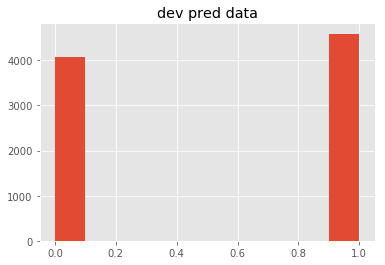

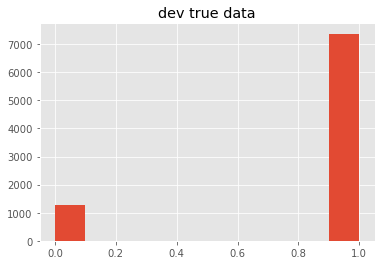

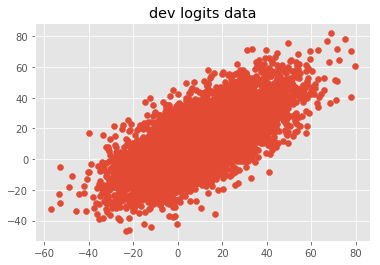

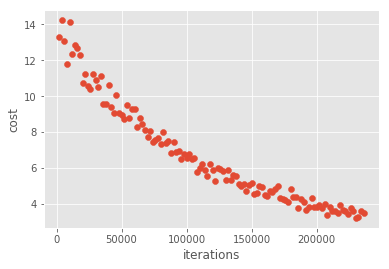

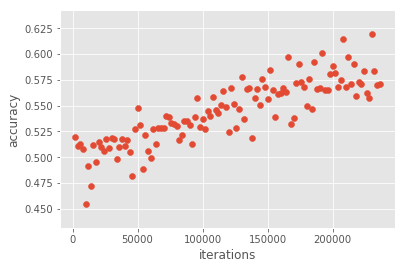

In [36]:
training_iters = 236000
batch_size = 1000
display_step = 2
learning_rate = 0.01
a=runSimpleNN(training_iters, batch_size, display_step, learning_rate)

### 4.2.2 LSTM

In [41]:
'''
A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.
This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

from __future__ import print_function

def run_LSTM(learning_rate_v ,training_iters_v ,batch_size_v ,sentence_size_v ,n_hidden_v, n_layer_v):
    import tensorflow as tf
    import sklearn as sk
    from tensorflow.contrib import rnn

    # Import MNIST data


    '''
    To classify images using a recurrent neural network, we consider every image
    row as a sequence of pixels. Because MNIST image shape is 28*28px, we will then
    handle 28 sequences of 28 steps for every sample.
    '''
    # Reset defaul graph.
    tf.reset_default_graph()
    tf.set_random_seed(42)

    ######################## 
    ### MODEL PARAMETERS ###
    ######################## 

    # 0.01 learning rate
    # 200k iterations
    # 1000 batch size
    # 10 context window
    # 50 hidden
    ## 70 sentence length


    # Parameters
    learning_rate = learning_rate_v
    training_iters = training_iters_v
    batch_size = batch_size_v
    display_step = 2
    sentence_size = sentence_size_v

    # Network Parameters
    n_input = 1  
    n_steps = sentence_size/n_input # timesteps
    n_hidden = n_hidden_v # hidden layer num of features
    n_classes = 2  
    vocab_size = 10000
    n_layer = n_layer_v


    #################################
    ### PLACEHOLDER AND VARIABLE ###
    #################################

    # tf Graph input
    ids_ = tf.placeholder(tf.int32, [None, n_steps, n_input], name="ids")
    y = tf.placeholder(tf.int32, [None, n_classes], name="y")

    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes]), name="W")
    }
    biases = {
        'out': tf.Variable(tf.zeros([n_classes], dtype=tf.float32), name="b")
    }


    ######################## 
    ### DEFINE RNN MODEL ###
    ######################## 
    def MakeFancyRNNCell(H, keep_prob, num_layers=1):
        """Make a fancy RNN cell.
        Use tf.nn.rnn_cell functions to construct an LSTM cell.
        Initialize forget_bias=0.0 for better training.
        Args:
          H: hidden state size
          keep_prob: dropout keep prob (same for input and output)
          num_layers: number of cell layers
        Returns:
          (tf.nn.rnn_cell.RNNCell) multi-layer LSTM cell with dropout
        """
        cells = []
        for _ in xrange(num_layers):
            cell = tf.contrib.rnn.BasicLSTMCell(H, forget_bias=0.0)
            cell = tf.contrib.rnn.DropoutWrapper(
              cell, input_keep_prob=keep_prob, output_keep_prob=keep_prob)
            cells.append(cell)
        return tf.contrib.rnn.MultiRNNCell(cells)


    # def RNN(x, weights, biases):

    with tf.name_scope("Embedding_Layer"):
        C_ = tf.Variable(tf.random_uniform([vocab_size, n_hidden],
                                           -1.0, 1.0), name="C")
        # embedding_lookup gives shape (batch_size, N, M)
        x_ = tf.reshape(tf.nn.embedding_lookup(C_, ids_), 
                        [-1, n_steps, n_input*n_hidden], name="x")


    #     with tf.variable_scope("first_lstm"+str(randint(0, 1000))):
    with tf.name_scope("Recurrent_Layer"):
        # Define a lstm cell with tensorflow
    #         lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden, state_is_tuple=True)
            lstm_cell = MakeFancyRNNCell(n_hidden, keep_prob = 1.0, num_layers=n_layer)
        # Get lstm cell output
            outputs, states = tf.nn.dynamic_rnn(lstm_cell, x_, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    with tf.name_scope("Output_Layer"):
        outputs=tf.transpose(outputs,[1,0,2])

        last_output = tf.gather(outputs,int(outputs.shape[0])-1)
        logits_ = tf.nn.softmax(tf.matmul(outputs[-1], weights['out']) + biases['out'])


    #############################
    ### LOSS AND OPTIMIZATION ###
    #############################

    with tf.name_scope("Cost_Function"):
        per_example_train_loss_ = tf.nn.softmax_cross_entropy_with_logits(
            logits=logits_, labels=y, name="per_example_train_loss")
        cost = tf.reduce_mean(per_example_train_loss_, name="loss")
    with tf.name_scope("Training"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


    ##################
    ### EVALUATION ###
    ################## 
    with tf.name_scope("Prediction"):
        pred_ = 1-tf.argmax(logits_,1)
        actual_labels_ = 1-tf.argmax(y,1)
        correct_pred_ = tf.equal(pred_, actual_labels_)
    with tf.name_scope("Scoring"):
        accuracy_ = tf.reduce_mean(tf.cast(correct_pred_, tf.float32))



    #################
    ### RUN GRAPH ###
    #################

    # Initializing the variables
    init = tf.global_variables_initializer()
    
    
    with tf.Session() as sess:
        sess.run(init)
        step = 1
        iters=[]
        costs=[]
        accs=[]
        f1s=[]
        precisions=[]
        recalls=[]
        iterator = PaddedDataIterator(train_df)

        # Keep training until reach max iterations
        while step * batch_size < training_iters:

            ##########################
            ### GENERATE BATCH X,Y ###
            ##########################
            batch_x, batch_y_1 = iterator.next_batch(batch_size,sentence_size)
            batch_y = np.concatenate((batch_y_1.reshape([-1,1]), 1-batch_y_1.reshape([-1,1])), axis=1)
            batch_x = batch_x.reshape((batch_size, n_steps, n_input))


            ################
            ### TRAINING ###
            ################
            out = sess.run(outputs,feed_dict={ids_: batch_x})

            sess.run(optimizer, feed_dict={ids_: batch_x, y: batch_y})

            #################
            ### REPORTING ###
            #################

            if step % display_step == 0:
                # Calculate batch accuracy, loss
                acc,loss = sess.run([accuracy_,cost], feed_dict={ids_: batch_x, y: batch_y})
                iters.append(step*batch_size)
                costs.append(loss)
                accs.append(acc)


            step += 1
        print("Optimization Finished!")

        ##########################
        ### EVALUATE WITH DEV DATA ###
        ##########################    

        batch_x_dev_1, batch_y_1_dev = PaddedDataIterator(dev_df).next_batch(len(dev_df),sentence_size)
        batch_x_dev = batch_x_dev_1.reshape([-1,n_steps, n_input])
        batch_y_dev = np.concatenate((batch_y_1_dev.reshape([-1,1]), 1-batch_y_1_dev.reshape([-1,1])), axis=1)

        dev_pred,dev_acc_labels,dev_acc, dev_cost,logits = sess.run(
            [pred_,actual_labels_,accuracy_, cost,logits_],
            feed_dict={ids_: batch_x_dev, y: batch_y_dev})
        precision = sk.metrics.precision_score(dev_acc_labels, dev_pred)
        recall = sk.metrics.recall_score(dev_acc_labels, dev_pred)
        f1 = sk.metrics.f1_score(dev_acc_labels, dev_pred)

        return (learning_rate ,training_iters ,batch_size ,sentence_size  ,n_hidden,n_layer),\
                (dev_acc,dev_cost,f1,precision,recall)

In [43]:
from itertools import product

learning_rate = [0.01, 0.01]
training_iters = [100000,200000]
batch_size = [100] 
sentence_size =[30,50,100]
n_hidden = [20,50]
n_layer = [1,2,3]
dic= {}
for learning_rate_v, training_iters_v,batch_size_v,sentence_size_v,n_hidden_v,n_layer_v \
    in product(learning_rate, training_iters ,batch_size,sentence_size,n_hidden,n_layer):
    a,b = run_LSTM(learning_rate_v, training_iters_v,batch_size_v,sentence_size_v,n_hidden_v,n_layer_v)
    dic[a]=b

Optimization Finished!
